# 2D Steady-State Flow on XCT image with PINN

This code solves 2D steady-state flow problems in heterogeneous porous media using Physics-informed Neural Networks (PINN) and the JAX library.

**PDE problem**:
$$ 
\frac{\partial}{\partial x} \left( k \frac{\rho}{\mu} \frac{\partial P}{\partial x} \right) + \frac{\partial}{\partial y} \left( k \frac{\rho}{\mu} \frac{\partial P}{\partial y} \right) = 0 
$$

**Boundary conditions**:
- $ P = 2 $ kPa at  x = 0 
- $ P = 1 $ kPa at  x = 1 
- $ \frac{\partial P}{\partial y} = 0 $ at y = 0 and  y = 1

**Developed by**:
Lal Mamud, Postdoc - Subsurface Modeler, Environmental Subsurface Science Group, Energy & Environment Division, Pacific Northwest National Laboratory, Richland, WA, USA.

**Mentors**:
Maruti K. Mudunuru and Satish Karra


## Imports Python packages and functions

In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import jax 
import jax.numpy as jnp
from jax import random, jit, grad, vmap
import optax
%load_ext autoreload
%autoreload 2

# import functions
current_directory = os.getcwd()                             # current directory
parent_directory = os.path.dirname(current_directory)       # parent directory
sys.path.append(parent_directory)                           # Add the parent directory to sys.path
from src.flow.plotting_results import *
from src.flow.pinn_utilities import *

## Loading and Processing XCT Data
In this section, we load the X-ray computed tomography (XCT) data from the specified file and perform several preprocessing steps necessary for subsequent analysis. ### Steps Involved:
1. *Loading XCT Data*
2. *Normalization*
3. *Plotting the Normalized XCT Data*
4. *Determining Data Dimensions*
5. *Generating Spatial Grid*

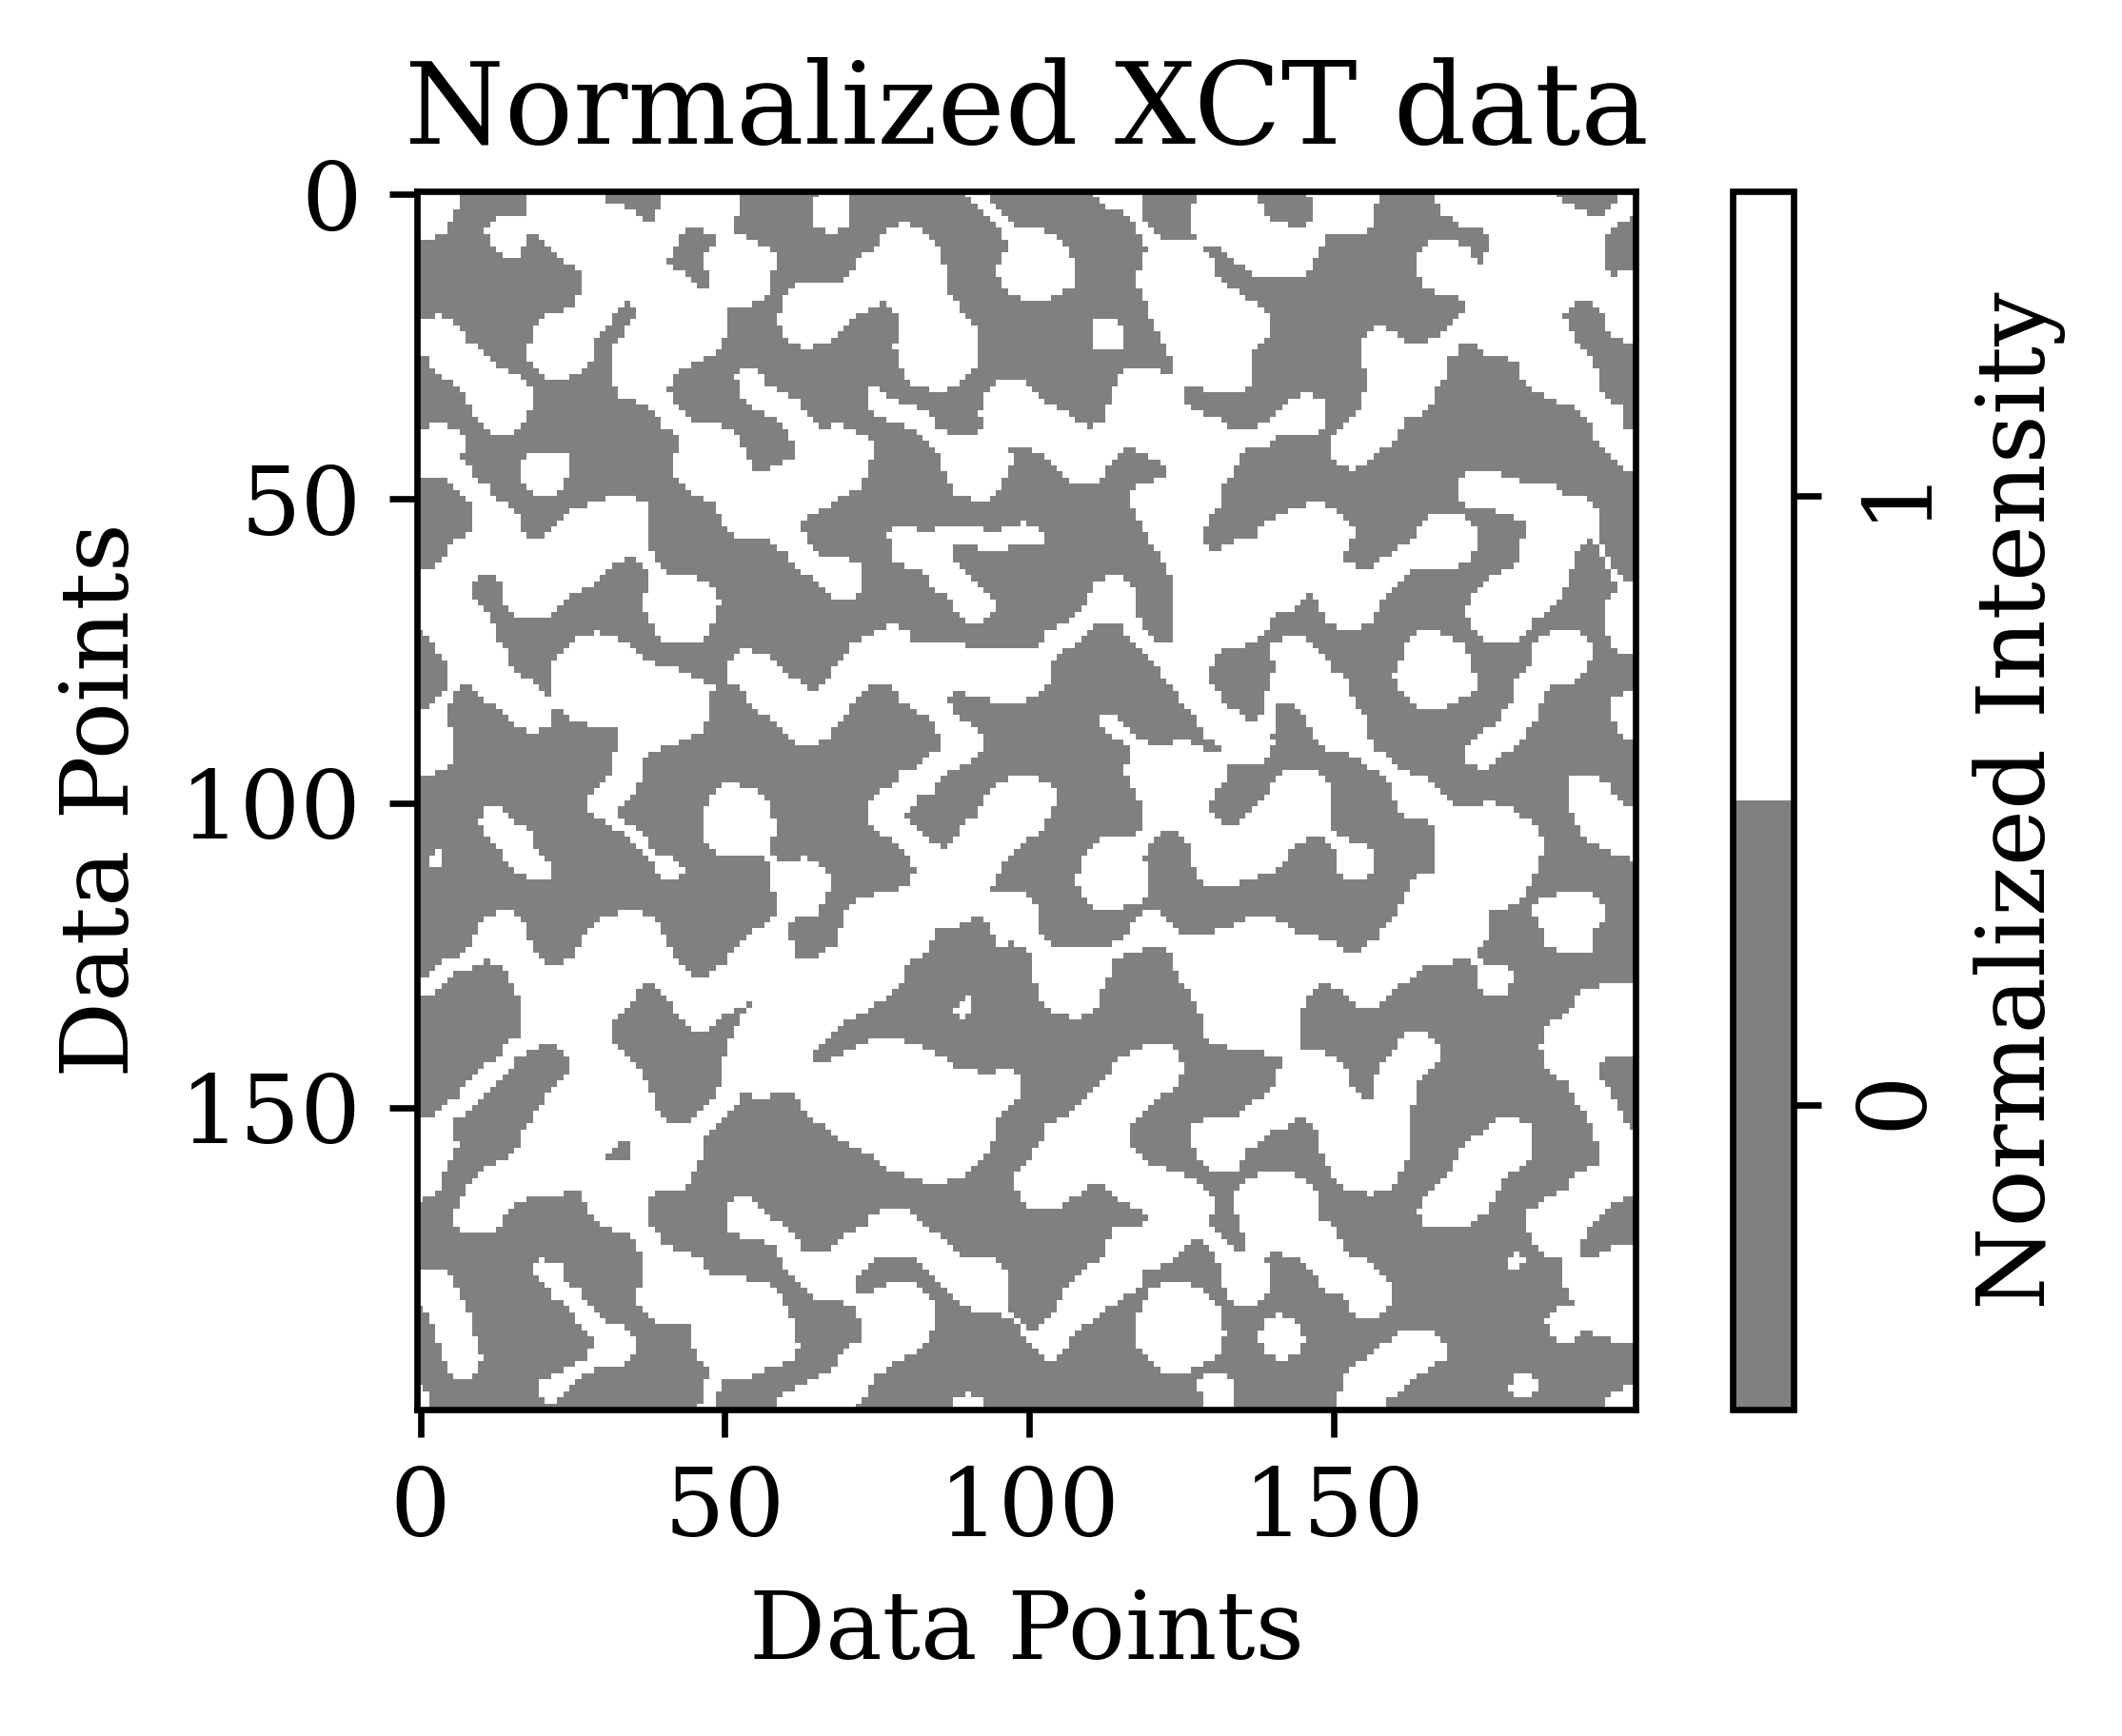

In [5]:
#%% loading XCT data from the file for domain and variable declarations
data_dir = "../example_outputs/"
results_dir = "../example_outputs/flow/"

data = np.load(data_dir + 'micromodel.npy')                      # Load the XCT data
normalized_xct_data = data/np.max(data)                          # Normalize the data to [0, 1]
plot_2d_xct_data_seg(normalized_xct_data, results_dir)           # Plot the normalized XCT data

# Determine the dimensions of the data
data_width, data_height = len(normalized_xct_data), len(normalized_xct_data) 

# Generate evenly spaced points in the interval [0, 1] for both dimensions
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0 , 1.0
x = np.linspace(xmin, xmax, data_width*1)
dx = x[1] - x[0]
nx = len(x)
y = np.linspace(ymin, ymax, data_height*1)
dy = y[1] - y[0]
ny = len(y)
X, Y = np.meshgrid(x, y)

## Permeability Field Generation Based on XCT Data
In this section, we generate a permeability field from the XCT data. Permeability is a key property in modeling fluid flow through porous media, and it varies depending on the material's structure, which is captured by the XCT data. The XCT data provides a spatial representation of the material, and we translate this into a spatially varying permeability field based on predefined permeability values for different regions (e.g., pores and soil matrix).

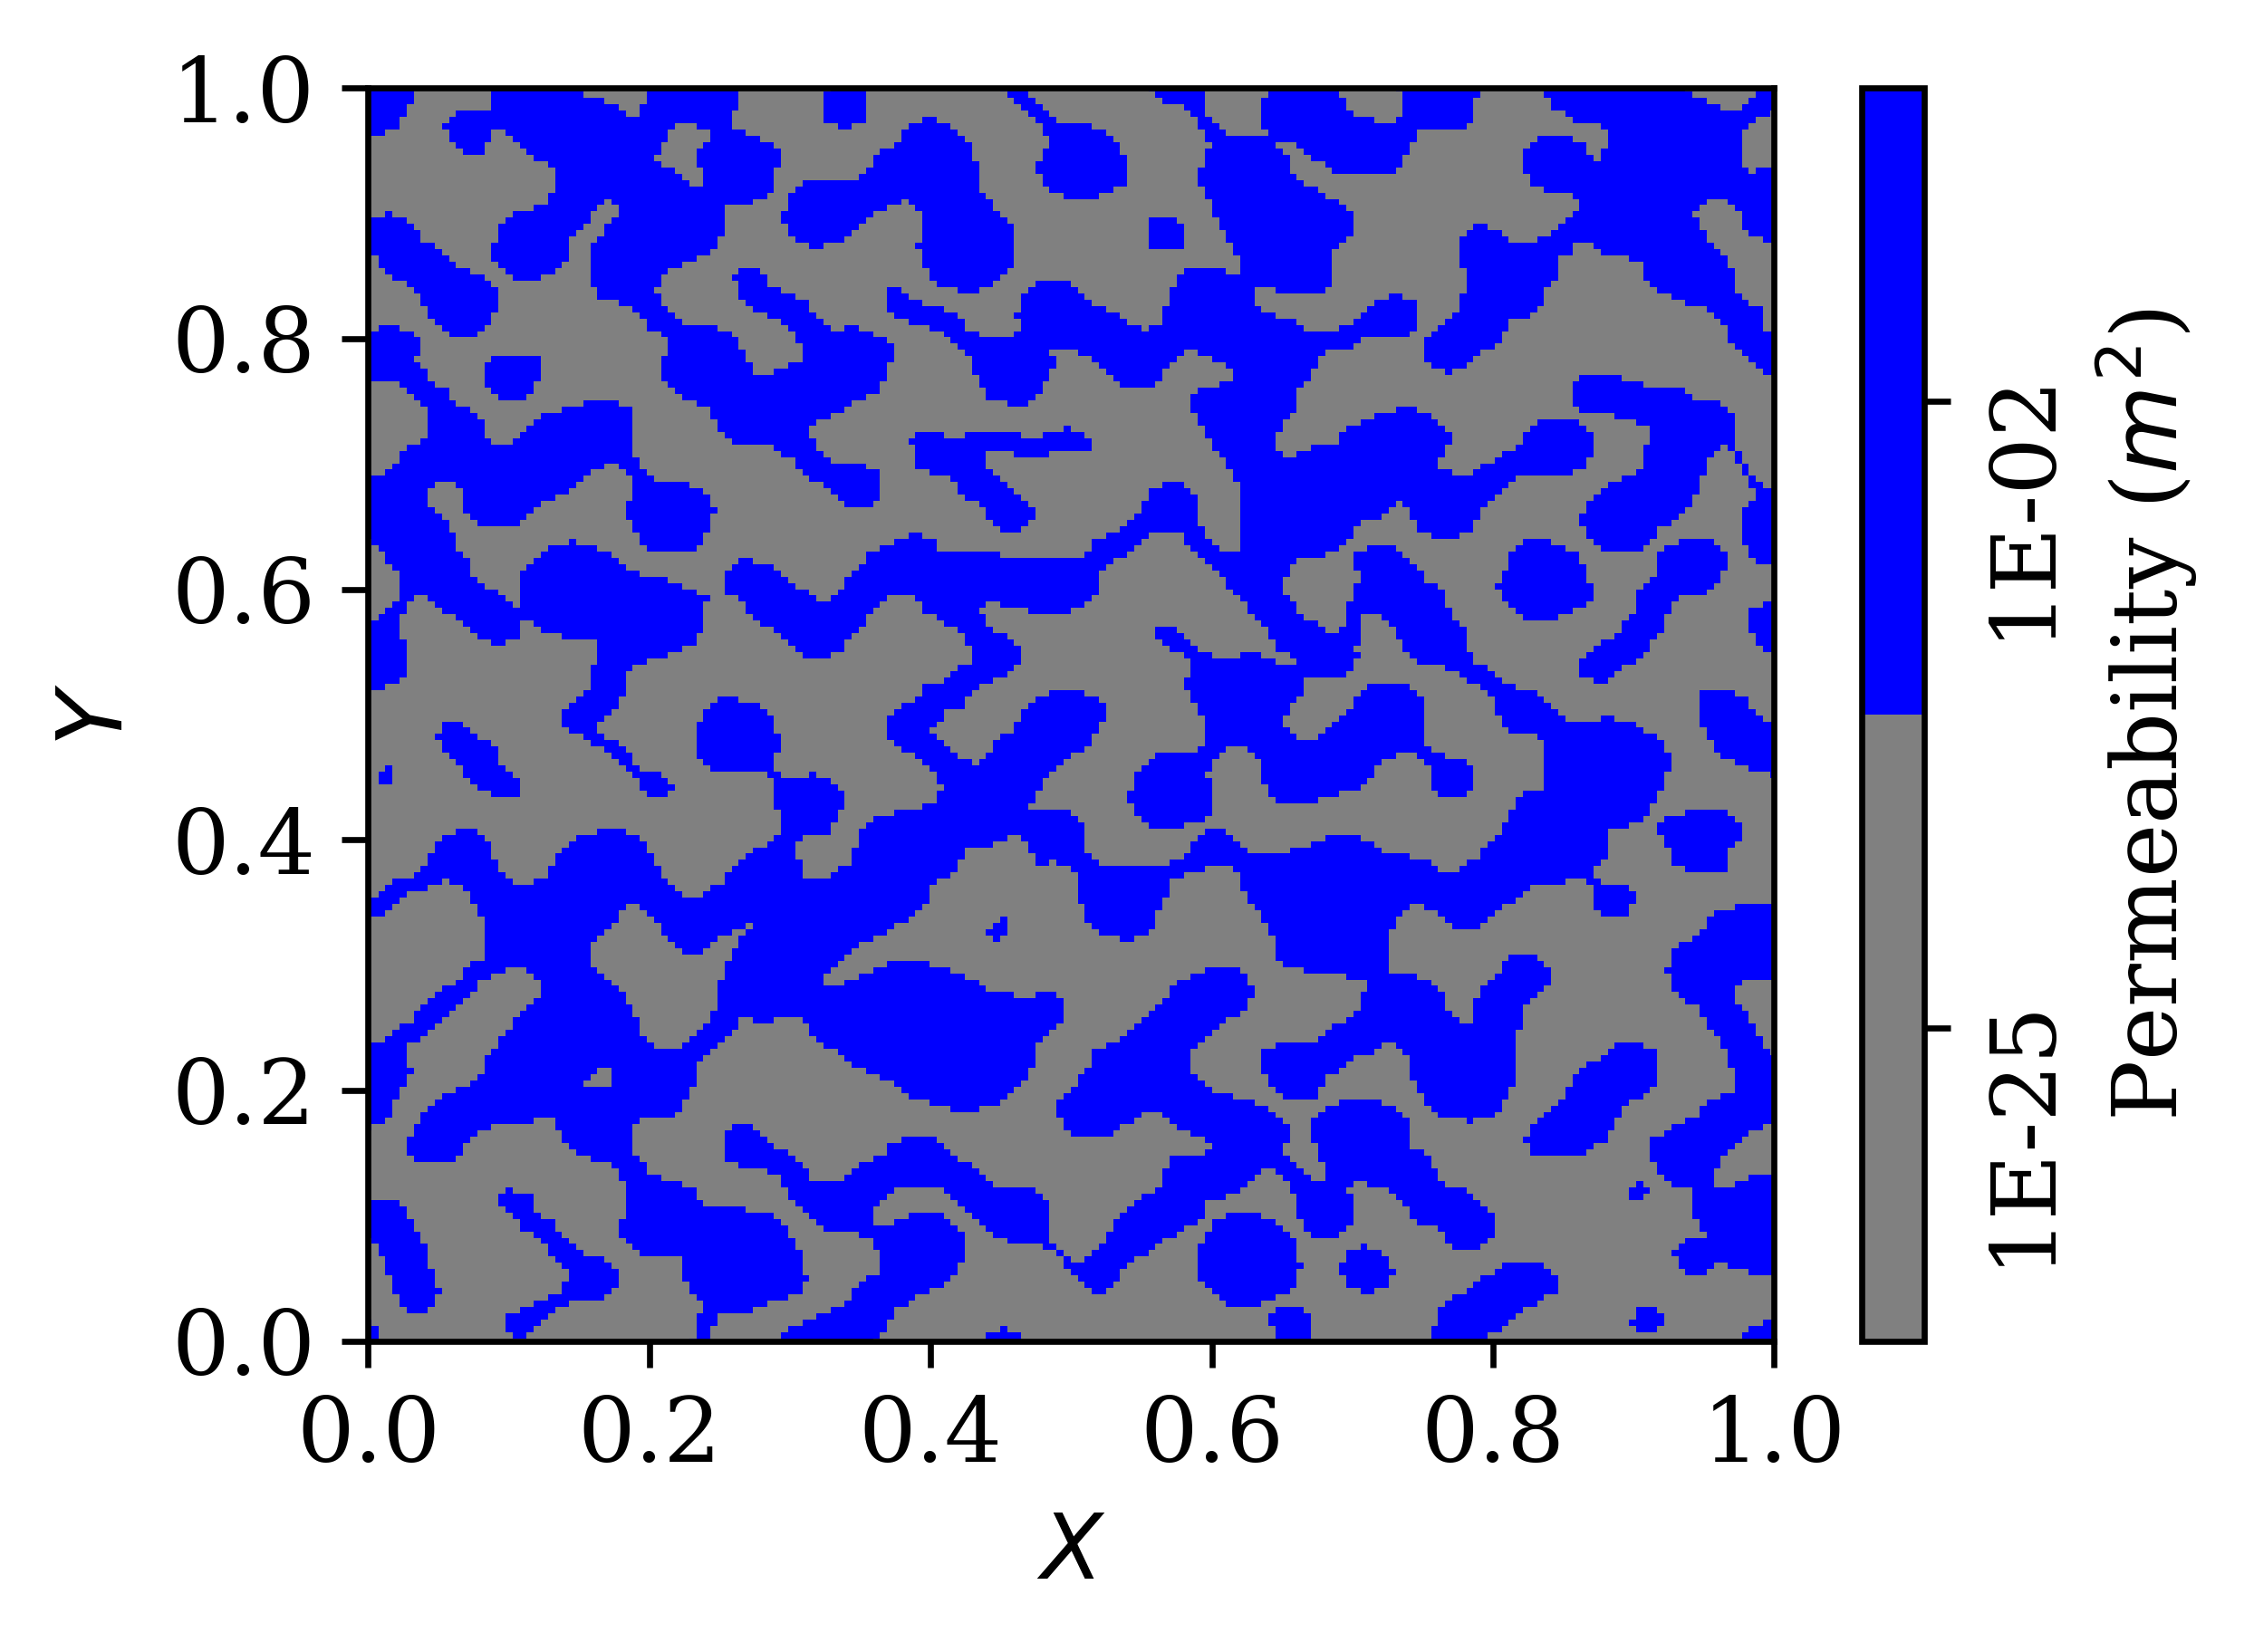

In [10]:
# Define the minimum permeability (soil matrix) and maximum permeability (pores)
k_min = 1E-25        # Assigned Permeability of soil matrix corresponding to the lower XCT values (1 𝑚^2/s)
k_max = 1E-2         # Assigned Permeability of pores corresponding to the higher XCT values (1 𝑚^2/s)

# Find the minimum and maximum values in the normalized XCT data
xct_val_min = np.min(normalized_xct_data)
xct_val_max = np.max(normalized_xct_data)

# Initialize a permeability field with the same dimensions as the XCT data,
#and assign the minimum permeability value (k_min) to all elements
perm_field_as_XCT = np.full_like(normalized_xct_data, fill_value = k_min)  

# Assign the maximum permeability value (k_max) to elements in the field 
# that corresponds to the maximum XCT values (pores)
perm_field_as_XCT[normalized_xct_data == np.max(normalized_xct_data)] = k_max  

# Flip the permeability field upside down to match the required orientation
perm_field = np.flipud(perm_field_as_XCT)

# Plot the final permeability field
plot_2d_permeability_seg(X, Y, perm_field, results_dir)

## Define Boundary Conditions and Input Parameters for PINN solution

In [9]:
# Define the boundary conditions and input parameters
P1 = 2.0             # at x = 0 for all y_b1, Dirichlet boundary at the left (kPa)  
P2 = 1.0             # at x = 1 for all y, Dirichlet boundary at the right (kPa)
dP_dy1 = 0           # at y = 0 for all x, Neumann boundary at the bottom (kPa)
dP_dy2 = 0           # at y = 1 for all x, Neumann boundary at the top (kPa)

# normalize the pressure value with its maximum value
max_P = max(P1, P2)
norm_P1 = P1 / max_P
norm_P2 = P2 / max_P

# Input parameters: Dynamic viscosity (mu), Density of water (rho), and Permeability (k). 
rho = 998                               # Density of water in kg/m³
mu = 1.002E-6                           # Dynamic viscosity (kPa·s)
coeff = perm_field * rho / mu           # Coefficient of Permeability calcualtions (k*rho/mu)
max_coeff = np.max(coeff)               # Coefficient of Permeability calcualtions (k*rho/mu)
norm_coeff = coeff/max_coeff

## Plot for Boundary Conditions and Collocation points associated with PINN

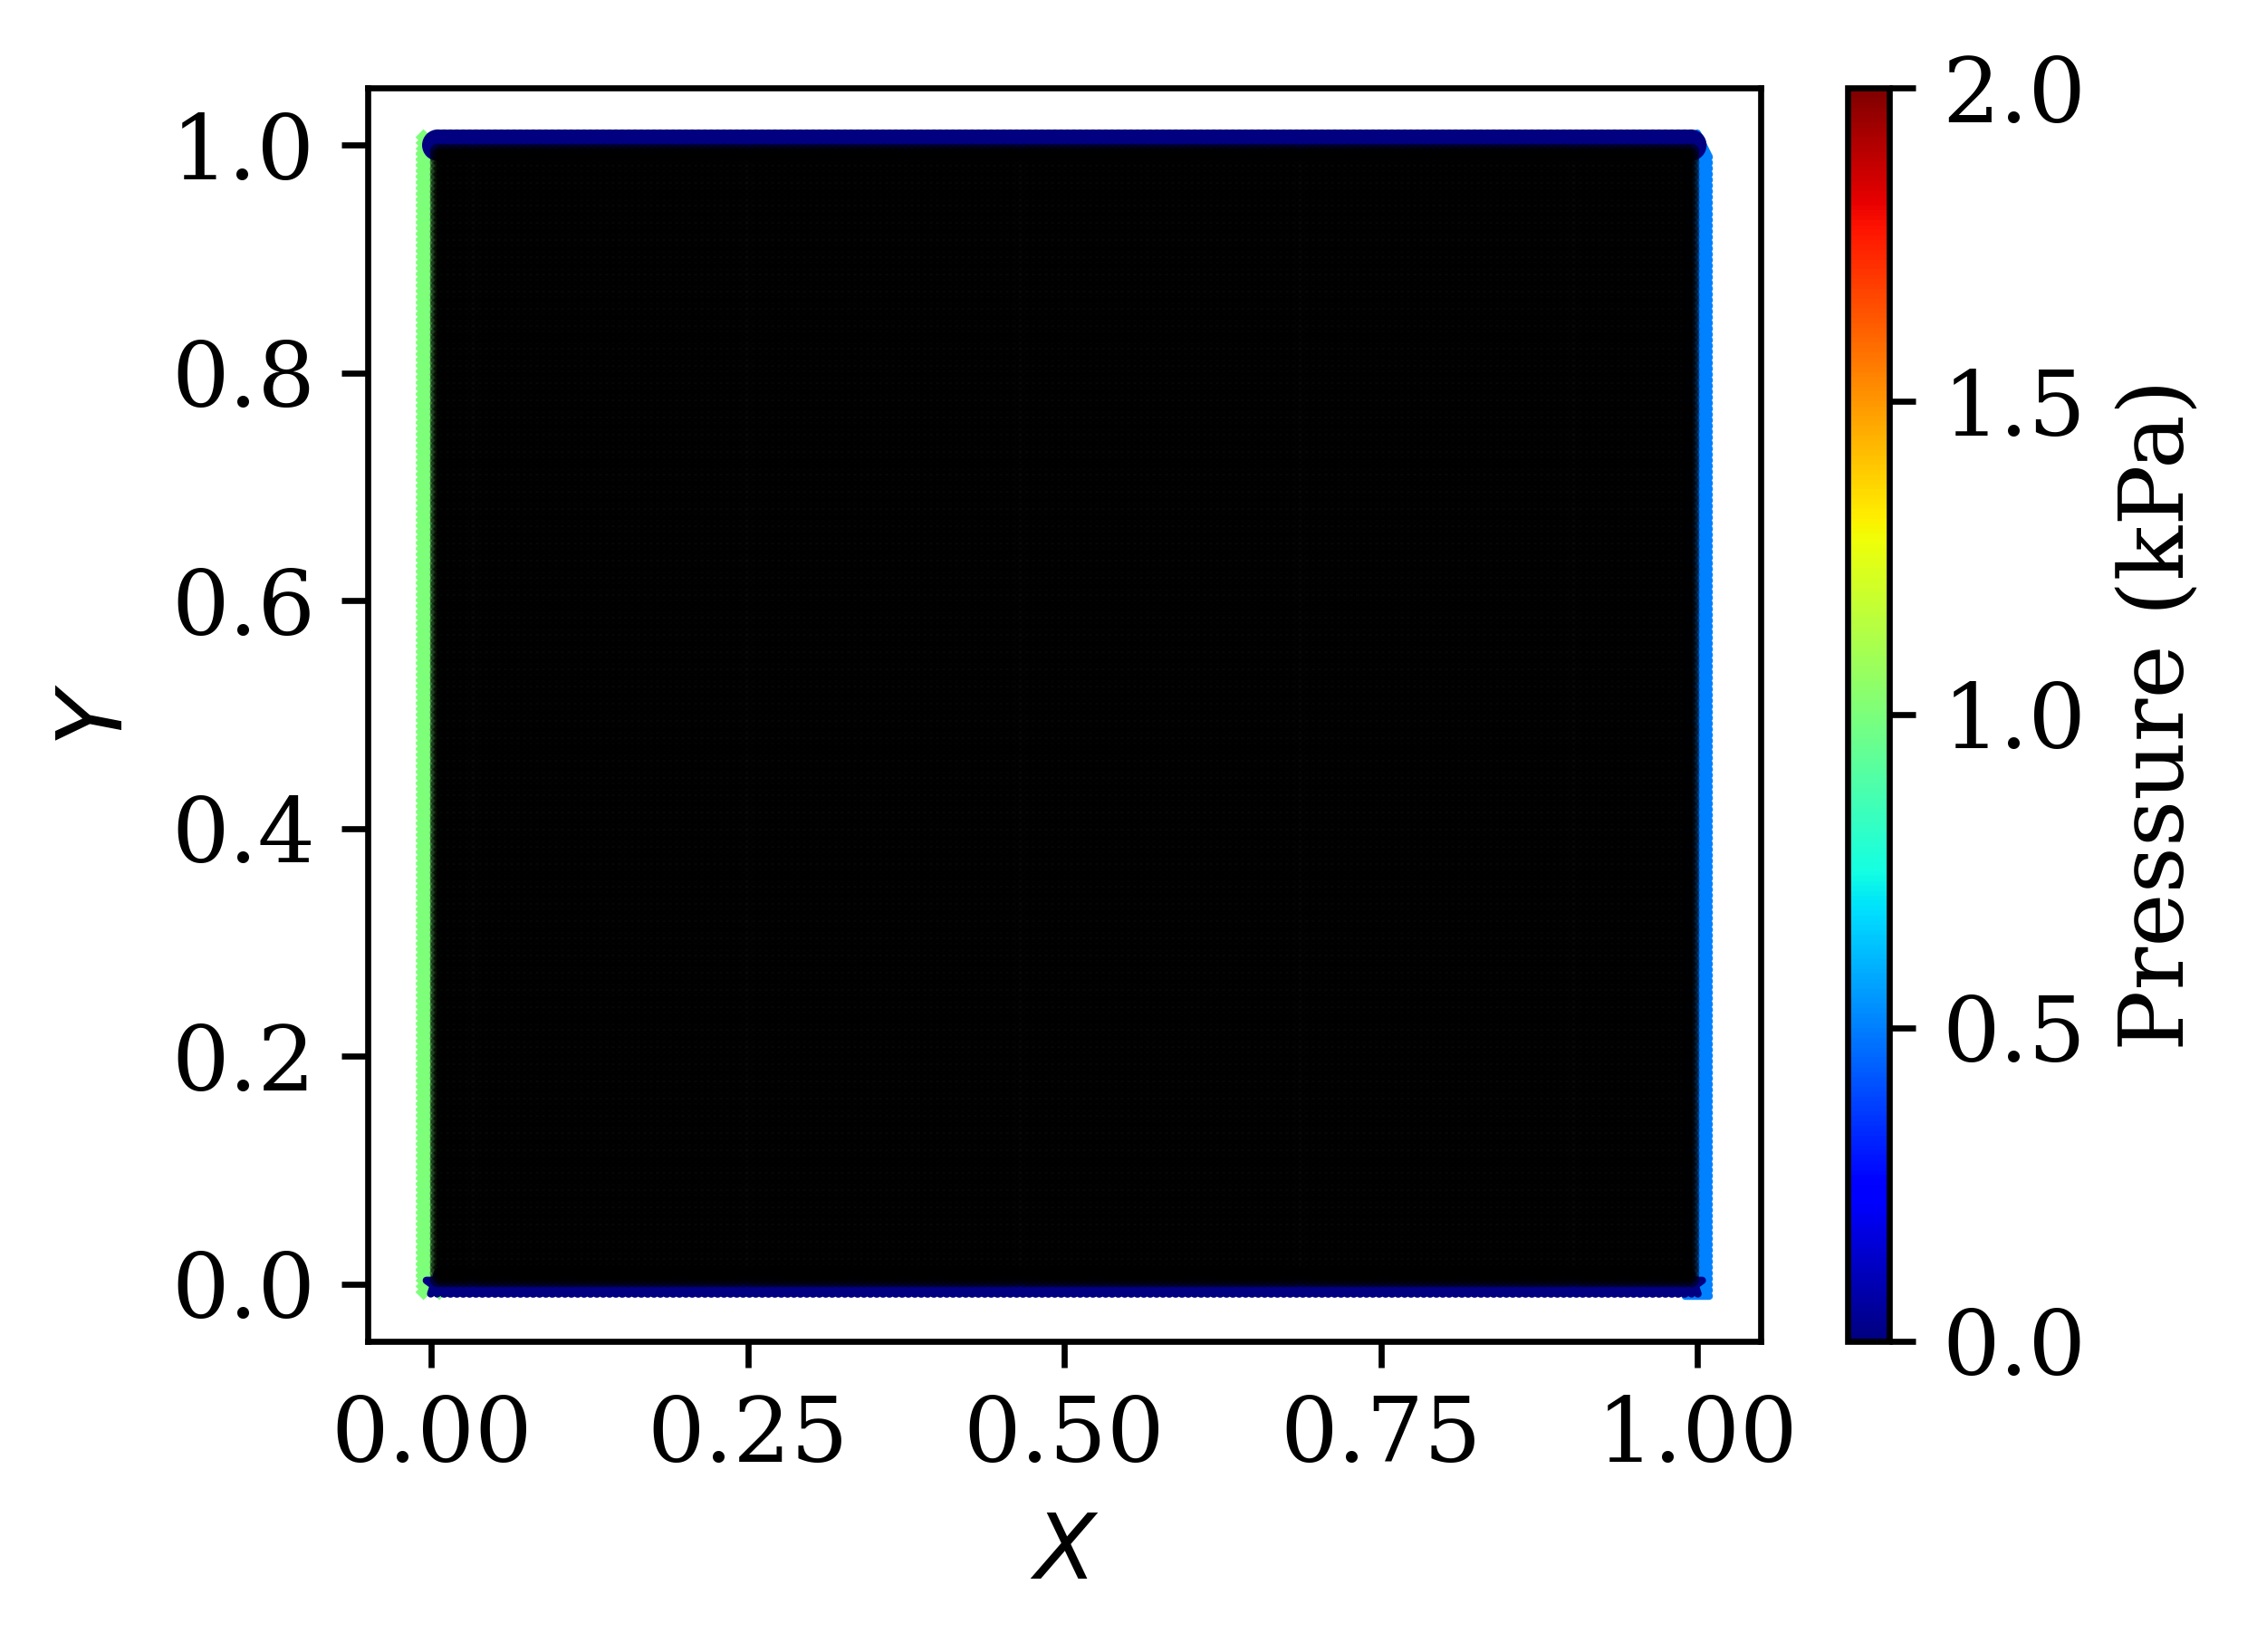

<Figure size 2580x1920 with 0 Axes>

In [11]:
# Plot for the Boundary conditions and collocation for training 
x_b1, y_b1, bc_1, x_b2, y_b2, bc_2, x_b3, y_b3, bc_3, x_b4, y_b4, bc_4, x_c, y_c, conds, colloc = generate_BCs_and_colloc_xct(X, Y, norm_P1, norm_P2, dP_dy1, dP_dy2) 

plot_boundary_conditions(x_b1, y_b1, bc_1, x_b2, y_b2, bc_2, x_b3, y_b3, bc_3, x_b4, y_b4, bc_4, x_c, y_c, results_dir)
save_legend_as_image(results_dir)

## Hyperparameters and PINN Training

In [ ]:
# Hyperparameters and PINN training
hidden_nodes = 20
hidden_layers = 3
lr = 1e-3
epochs = 2000
# construct the MLP 
params = init_params([2] + [hidden_nodes] * hidden_layers + [1])          
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

print('-------------------------------------------------------')
print('numbers of hidden layer = ', hidden_layers)
print('numbers of node = ', hidden_nodes)
print('learning rate = ', lr)
print('epoch = ', epochs)
print('-------------------------------------------------------')

# PINN training
best_params, best_loss, all_losses, all_epochs = train_PINN(params, epochs, optimizer, loss_fun, colloc, conds, norm_coeff, hidden_layers, hidden_nodes, lr, results_dir)

-------------------------------------------------------
numbers of hidden layer =  3
numbers of node =  20
learning rate =  0.001
epoch =  2000
-------------------------------------------------------
PINN training started...
   Epoch=0	 loss=6.020e-01


## PINN Prediction

In [7]:
# PINN prediction
norm_pinn_P = (neural_net(best_params, X.flatten().reshape(-1,1), Y.flatten().reshape(-1,1))).reshape(nx,ny)  
pinn_P = norm_pinn_P * max_P

## Plotting Results

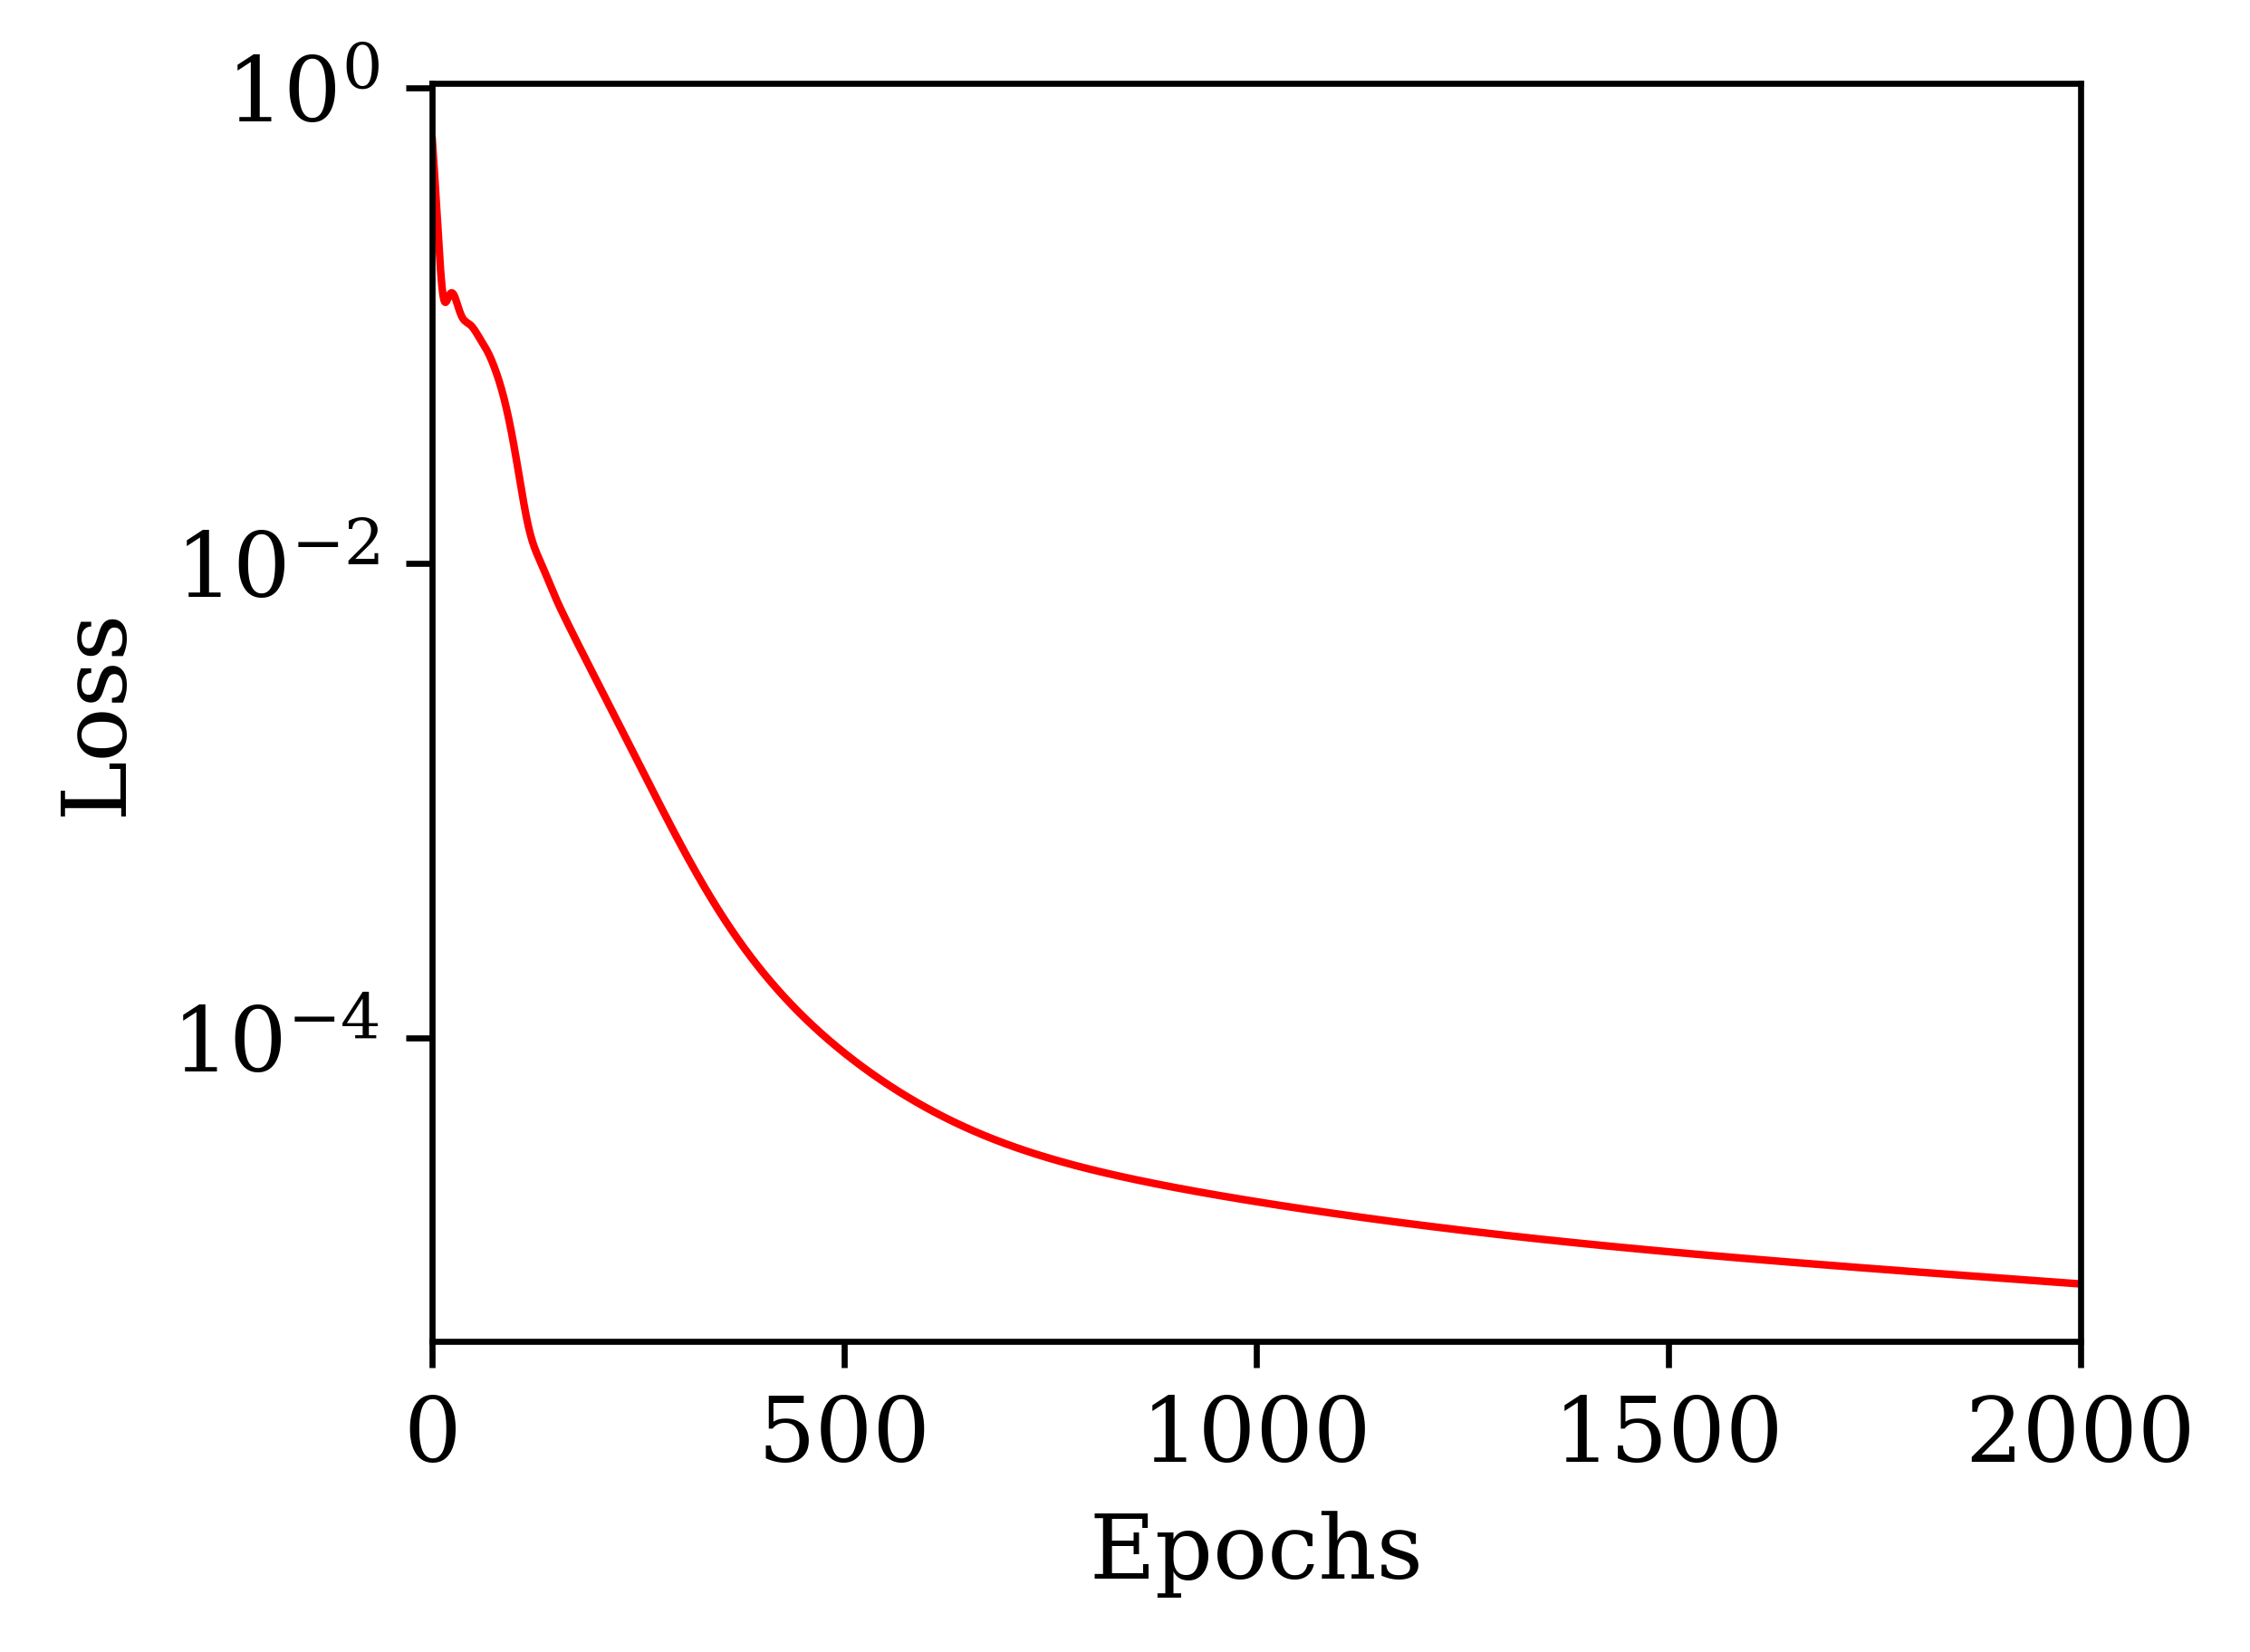

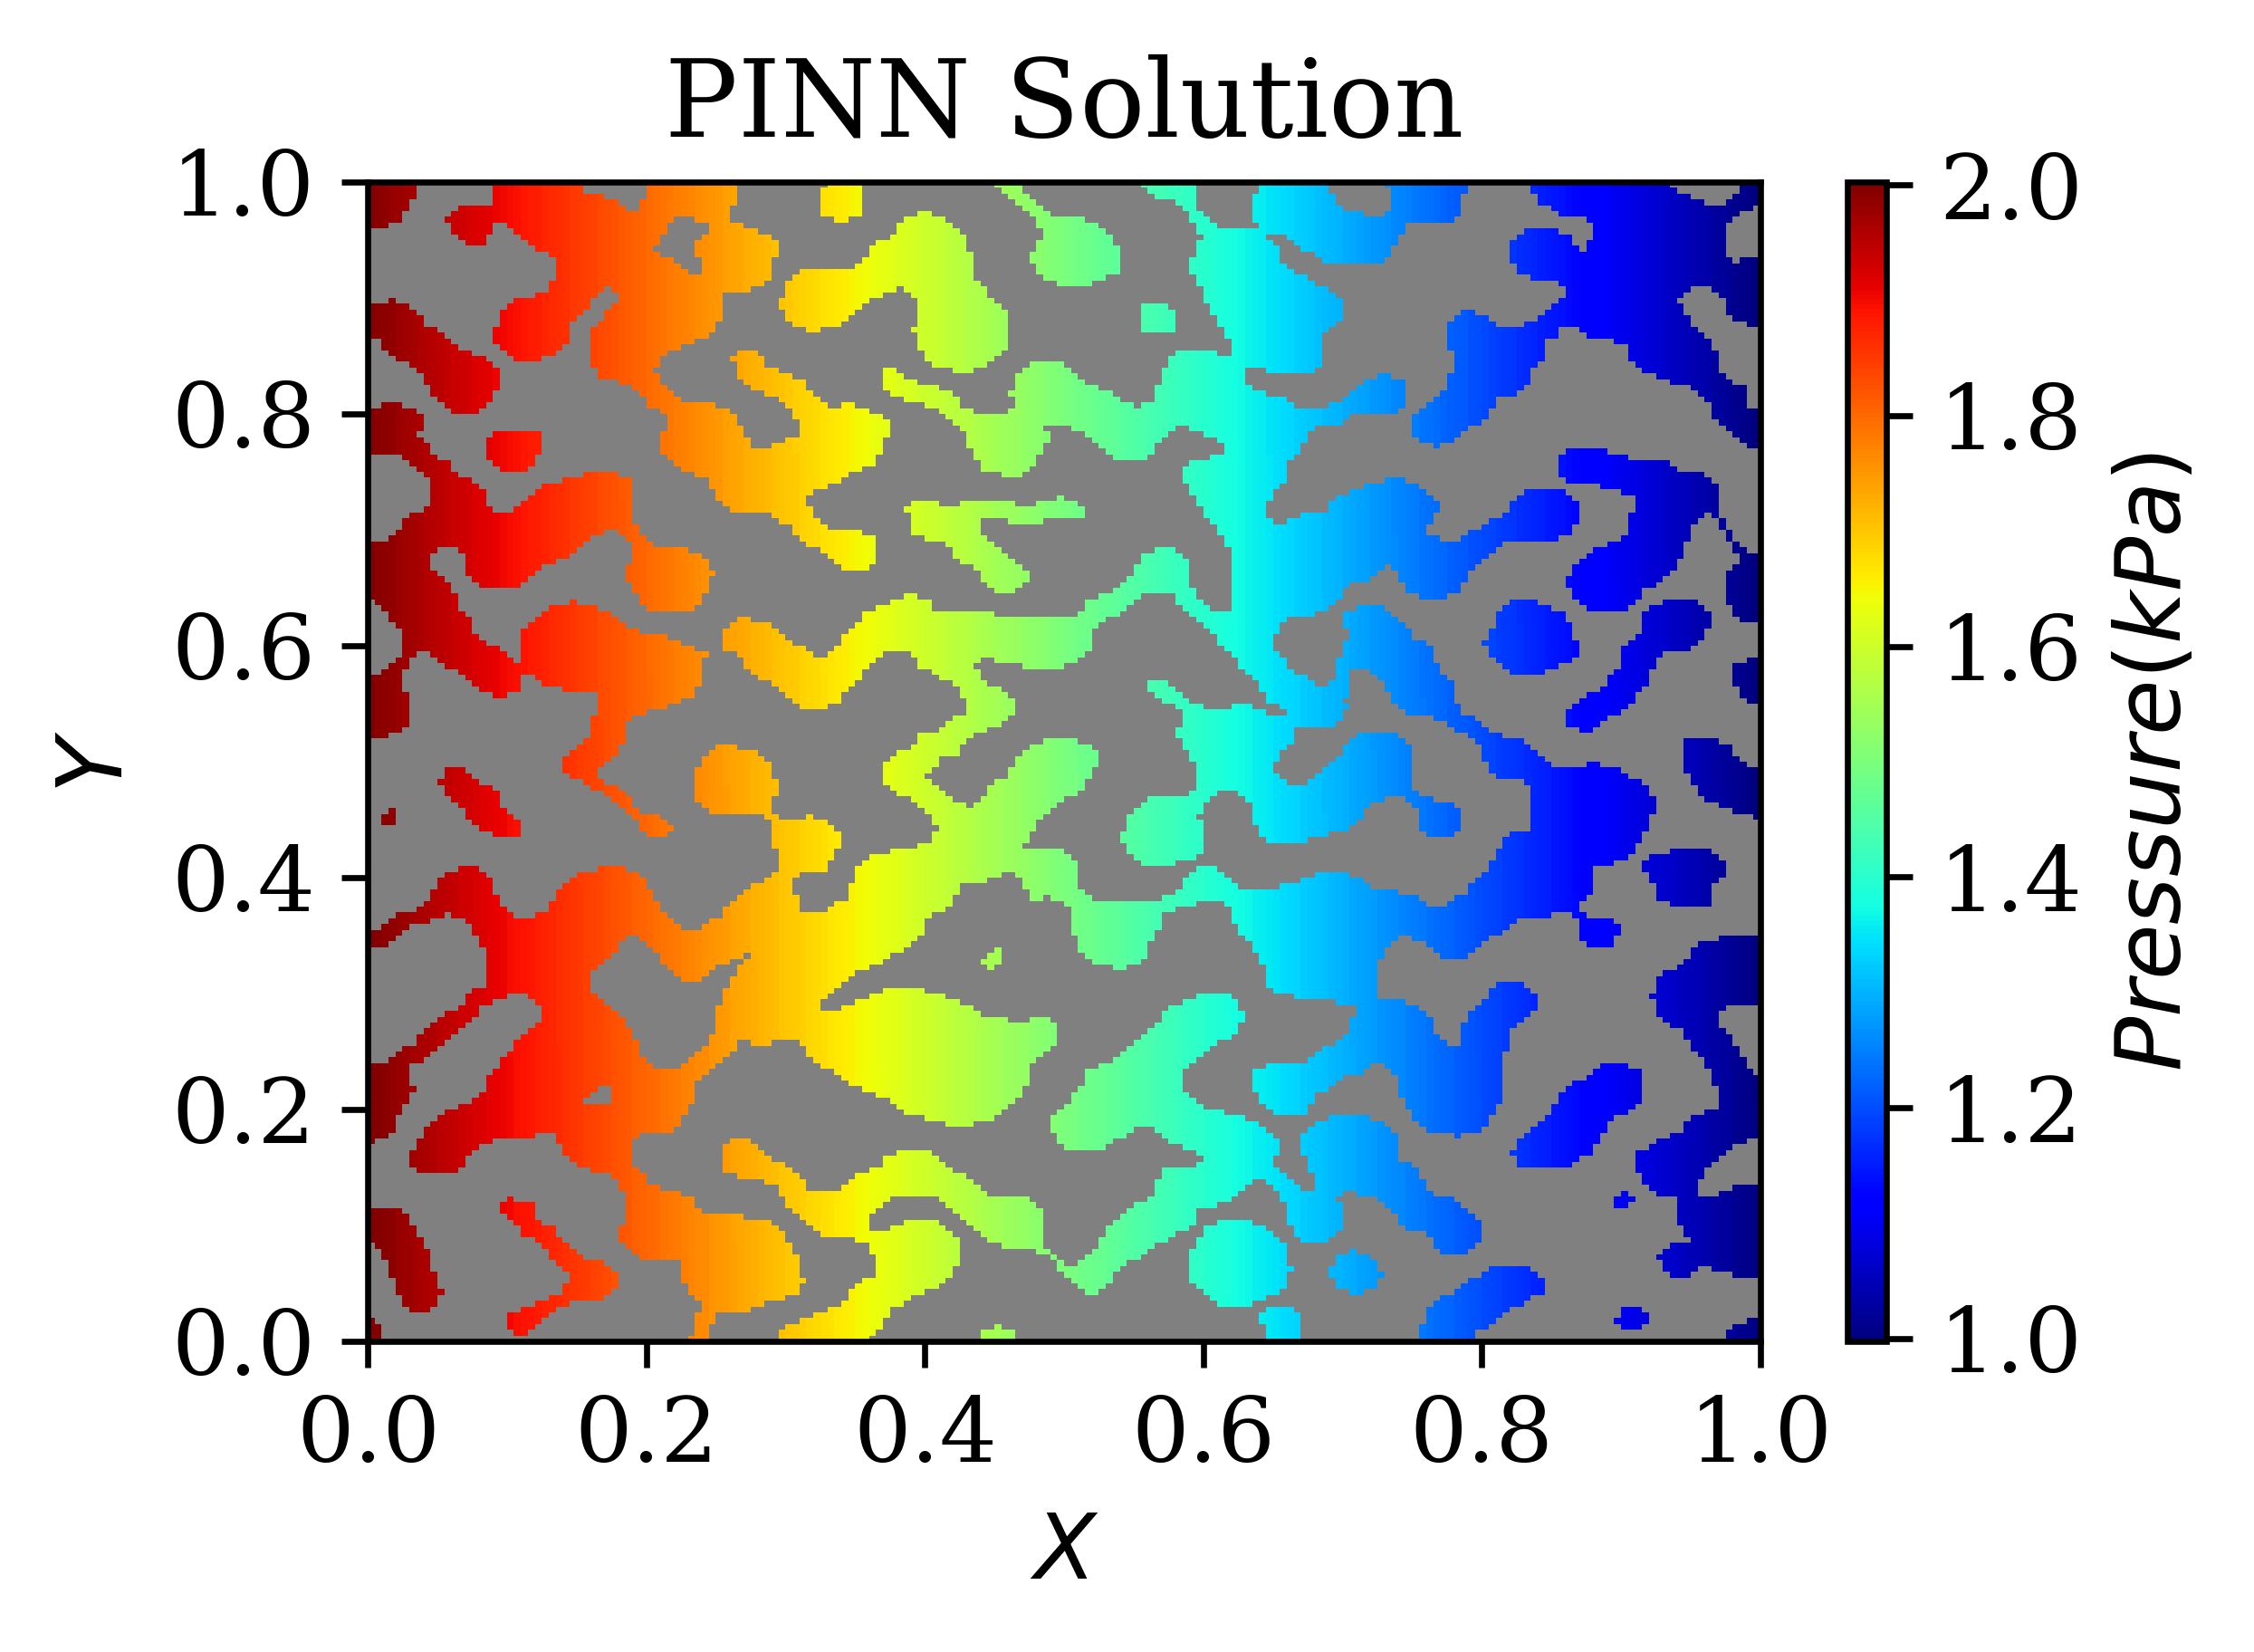

In [8]:
# Plotting results
# plot loss vs. epoch
title = 'PINN Prediction'
fig_name = 'pinn_training'
plot_pinn_training(all_losses, all_epochs, title, fig_name, results_dir)  

# # plot PINN predicted head distribution
# title = 'PINN Prediction'
# fig_name = 'pinn_solution'
# cbar_lebel = "$Pressure (kPa)$"
# plot_2d_pressure_distribution(X, Y, pinn_P, cbar_lebel, title, fig_name, results_dir)      

# # pressure line plots in the middle of y axis along the x direction
# fig_name = 'pinn_solution_1d_pressure'
# title = 'PINN predicted pressure'
# plot_pressure_along_x(X, Y, pinn_P, title, fig_name, results_dir)

# Plot pressure distribution masked soil skeleton
title = 'PINN Solution'
fig_name = 'PINN_solution_masked'
cbar_lebel = "$Pressure (kPa)$"
masked_pressure = plot_2d_pressure_distribution_masked(X, Y, pinn_P, perm_field, cbar_lebel, title, fig_name, results_dir)

# # pressure line plots in the middle of y axis along the x direction (masked)
# fig_name = 'PINN_solution_1d_pressure_masked'
# title = 'PINN simulated pressure'
# plot_pressure_along_x(X, Y, masked_pressure, title, fig_name, results_dir)

# save results
np.savez(results_dir + 'pinn_solution.npz', Pressure=pinn_P, X=X, Y=Y, Permeability=perm_field)